# Neural Network Logit Test


Xiuyuan Cheng

xiuyuan.cheng@duke.edu

-----

Classification two-sample test (C2ST) by neural network logit test

This file produces

- The 1D data example in Fig 5 (also shown as Example 3 in Fig 6) of the paper "Classification logit two-sample testing by neural networks for differentiating near manifold densities", TIT 2022 (arxiv:1909.11298). This is 1D data. 


- Performance of NN logit test on the high dimensional Gaussian mixture data, the example in Fig 3 of "Learning deep kernels for non-parametric two-sample tests", ICML 2020 (arXiv:2002.09116). This is high dimensional data.

In [2]:
import matplotlib.pyplot as plt 
import numpy as np

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F

In [3]:
device = torch.device("cpu")

np.random.seed(2022)

## 1. Example of 1D data

Mixture with bump at tail,

X ∼ N (0, 1),

Y ∼ (1−delta) * N (0, 1) + delta * N (3, 1/16 )

delta = 0.08, n_all = 400, n_run=400, m_perm = 400, test power is averaged over n_rep = 20 replicas.

In [4]:
# classification network architecture
num_neurons = 32; #paper has 32, using larger width can work with shorter training epochs
#num_neurons = 256;
dim = 1;
    
class nn_two_hidden_layer_classif(nn.Module):
    def __init__(self):
        super( nn_two_hidden_layer_classif, self).__init__()
        input_dim = dim
        num_classes = 2
        
        self.fc1 = nn.Linear(input_dim, num_neurons ) 
        self.fc2 = nn.Linear(num_neurons, num_neurons) 
        self.fc3 = nn.Linear(num_neurons, num_classes) 

    def forward(self, x):        
        x = F.relu(self.fc1(x)) #relu activation function
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

In [5]:
# train and test for classification network
def train_loop(dataloader, model, optimizer):
    num_classes= 2 
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0 
    for batch, (train_features, train_labels) in enumerate(dataloader):
        # forward pass
        outputs = model(train_features).reshape([-1,num_classes]) 
        pred = F.log_softmax(outputs, dim=1)
        this_batch_size = len(train_labels)
        loss = F.nll_loss( pred, 
                  train_labels.reshape([this_batch_size]), reduction='sum')
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward() #compute both the loss and the gradient fields of trainable parameters
        optimizer.step() #apply the stochastic optimization scheme
        
        train_loss += loss.item()    
        correct += (pred.argmax(1) == train_labels).type(torch.float).sum().item()
    
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(train_features)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= size
    correct /= size  
    #print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")  
    return train_loss, correct


def test_loop(dataloader, model):
    num_classes= 2 
    size = len(dataloader.dataset)
    #batch_size = dataloader.batch_size
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (test_features, test_labels) in dataloader:
            # forward pass
            outputs = model(test_features).reshape([-1,num_classes])
            pred = F.log_softmax(outputs, dim=1)
            
            this_batch_size = len(test_labels)
            loss = F.nll_loss( pred, 
                  test_labels.reshape([this_batch_size]), reduction='sum')
        
            test_loss += loss.item()
            correct += (pred.argmax(1) == test_labels).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")  
    return test_loss, correct

In [6]:
# 1D data, Eg. 3
def gen_1DEg3_P(n):
    dim = 1
    Num_clusters = 1 # number of modes
    mu_mx = np.zeros([Num_clusters,dim])
    sigma_mx = [np.identity(dim)]

    
    X = np.zeros([n, dim])
    X = np.random.multivariate_normal(mu_mx[0], sigma_mx[0], n)
    return np.float32(X)

def gen_1DEg3_Q(n, delta):
    dim = 1
    Num_clusters = 2 # number of modes
    mu_mx = np.zeros([Num_clusters,dim])
    mu_mx[1] = mu_mx[1] + 3.0
    sigma_mx_2 = [np.identity(dim), np.identity(dim)] 
    sigma_mx_2[1][0] = 1.0/16.0
    
    n_m1= np.int(n*(1-delta)) #mode1
    n_m2= n-n_m1     #mode2
    X = np.zeros([n, dim])
    X[0:n_m1, :] = np.random.multivariate_normal(mu_mx[0], sigma_mx_2[0], n_m1)
    X[n_m1:n, :] = np.random.multivariate_normal(mu_mx[1], sigma_mx_2[1], n_m2)
    return np.float32(X)

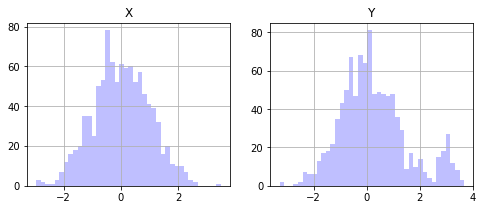

In [7]:
# generate data and visualize the histogram
nX,nY = 1000,1000
delta = 0.08
X = gen_1DEg3_P(nX);
Y = gen_1DEg3_Q(nY, delta);

plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
plt.hist( X, bins=40, facecolor='b', alpha=0.25)
plt.grid()
plt.title('X')
plt.subplot(1,2,2)
plt.hist( Y, bins=40, facecolor='b', alpha=0.25)
plt.grid()
plt.title('Y')
plt.show()

In [8]:
# the bootstrap procedure to estimate test threshold (permutation test)
def perm_test(gte, labels_te, numperm):
    idx1_te = (labels_te == 0).nonzero(as_tuple=True)[0].numpy()
    idx2_te = (labels_te == 1).nonzero(as_tuple=True)[0].numpy()
    eta = np.mean(gte[idx1_te])-np.mean(gte[idx2_te])
        
    # test-only boostrap (permutation test)
    etastore = np.float32( np.zeros(numperm) )
    for iboot in range(numperm):
        tmp=torch.randperm(ntr).numpy()
        idx1_perm, idx2_perm = tmp[0:nXte], tmp[nXte:nte] 
        eta_perm = np.mean(gte[idx1_perm])-np.mean(gte[idx2_perm])
        etastore[iboot] = eta_perm
        
    talpha = np.quantile(etastore, 0.95) #test level alpha=0.05
    return eta, etastore, talpha

In [9]:
# data parameters
delta_list = np.array([0, 0.08])
print(f'delta_list = {delta_list}')

# training and test set sizes
n_all = 400

ntr = n_all/2    
nXtr = np.int(ntr/2)
nYtr = nXtr
nXte, nYte = nXtr, nYtr
nX, nY = nXtr+nXte, nYtr+nYte
ntr, nte = nXtr+nYtr, nXte+nYte
print(f'ntr={ntr:d}, nXtr={nXtr:d}, nYtr={nYtr:d}')

# testing parameters
m_perm = 400 # boostrap parameter
n_run = 400 #400 #50 # number of tests to count rejectoin rate
n_replica = 20 #20 #10 #overall replicas
    #change n_run, n_replica to be smaller to run in shorter time
    # n_run=400, n_replica = 20 takes about 5 min to run

# c2st training parameter
learning_rate_c = 1e-3
batch_size = 100
#epochs =  np.int(100*600/ntr)
epochs =  100 #20 #100
print(f'epochs={epochs:d}, batch_size={batch_size:d}\n')

delta_list = [0.   0.08]
ntr=200, nXtr=100, nYtr=100
epochs=100, batch_size=100




 delta=0.000000, replica=0

C2ST-S power=0.0375, C2ST-L power=0.06


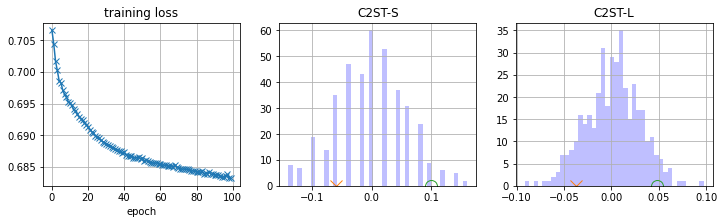

C2ST-S power=0.0225, C2ST-L power=0.0425
C2ST-S power=0.0225, C2ST-L power=0.0525
C2ST-S power=0.055, C2ST-L power=0.0575
C2ST-S power=0.0425, C2ST-L power=0.0625
C2ST-S power=0.04, C2ST-L power=0.05
C2ST-S power=0.0575, C2ST-L power=0.0725
C2ST-S power=0.045, C2ST-L power=0.0475
C2ST-S power=0.0275, C2ST-L power=0.0475
C2ST-S power=0.03, C2ST-L power=0.065

 delta=0.000000, replica=10

C2ST-S power=0.02, C2ST-L power=0.04
C2ST-S power=0.0425, C2ST-L power=0.05
C2ST-S power=0.0375, C2ST-L power=0.05
C2ST-S power=0.025, C2ST-L power=0.04
C2ST-S power=0.0, C2ST-L power=0.05
C2ST-S power=0.0475, C2ST-L power=0.0375
C2ST-S power=0.0475, C2ST-L power=0.0525
C2ST-S power=0.035, C2ST-L power=0.06
C2ST-S power=0.025, C2ST-L power=0.045
C2ST-S power=0.005, C2ST-L power=0.04

 delta=0.080000, replica=0

C2ST-S power=0.2175, C2ST-L power=0.865


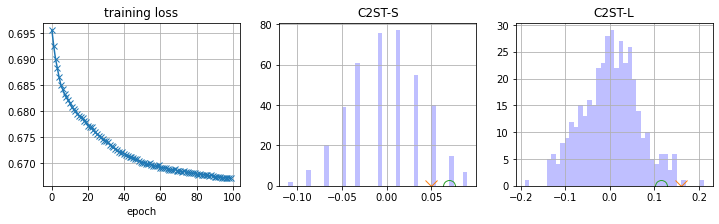

C2ST-S power=0.485, C2ST-L power=0.9025
C2ST-S power=0.33, C2ST-L power=0.76
C2ST-S power=0.0, C2ST-L power=0.8925
C2ST-S power=0.275, C2ST-L power=0.57
C2ST-S power=0.8, C2ST-L power=0.6575
C2ST-S power=0.0, C2ST-L power=0.765
C2ST-S power=0.325, C2ST-L power=0.5925
C2ST-S power=0.1225, C2ST-L power=0.5275
C2ST-S power=0.0775, C2ST-L power=0.855

 delta=0.080000, replica=10

C2ST-S power=0.06, C2ST-L power=0.8725
C2ST-S power=0.37, C2ST-L power=0.8025
C2ST-S power=0.32, C2ST-L power=0.745
C2ST-S power=0.1425, C2ST-L power=0.5575
C2ST-S power=0.4825, C2ST-L power=0.665
C2ST-S power=0.18, C2ST-L power=0.6775
C2ST-S power=0.19, C2ST-L power=0.56
C2ST-S power=0.1225, C2ST-L power=0.7375
C2ST-S power=0.195, C2ST-L power=0.6725
C2ST-S power=0.17, C2ST-L power=0.6075
Running time: 301.9877369403839 seconds


In [10]:
import time

c2st_s_vote_adam = np.zeros([ delta_list.shape[0], n_replica, n_run ])
c2st_l_vote_adam = np.zeros([ delta_list.shape[0], n_replica, n_run ])

start = time.time() #time the code

for irow in range(delta_list.shape[0]):
    delta = delta_list[irow]
    
    for irep in range(n_replica):
        if np.mod(irep,10) == 0:
            print(f'\n delta={delta:3f}, replica={irep:d}\n')
    
        ## generate data, training-testing splitting
        X = gen_1DEg3_P(nX);
        Y = gen_1DEg3_Q(nY, delta);
        idxX=torch.randperm(nX).numpy()
        idxY=torch.randperm(nY).numpy()
        data_tr = torch.tensor( np.concatenate( (X[idxX[0:nXtr],:],  Y[idxY[0:nYtr],:]), axis=0) )
        labels_tr = torch.tensor(np.concatenate( (np.zeros(nXtr),  np.ones(nYtr)), axis=0), dtype=int)        
        #data_te =  torch.tensor(np.concatenate( (X[idxX[nXtr:nX],:],  Y[idxY[nYtr:nY],:]), axis=0))
        #labels_te = torch.tensor(np.concatenate( (np.zeros(nXte),  np.ones(nYte)), axis=0), dtype=int)

        ### C2ST-S test: training ###
        model_c = nn_two_hidden_layer_classif().to(device) #init model
        training_data = torch.utils.data.TensorDataset(data_tr, labels_tr )
        train_dataloader = torch.utils.data.DataLoader(training_data, 
                                        batch_size= batch_size, shuffle=True)
        
        #init model
        model_c = nn_two_hidden_layer_classif().to(device) 
        # optimizer
        optimizer_c = optim.Adam(model_c.parameters(), 
                                   lr= learning_rate_c)
        model_c.train()

        # loop of training
        train_loss_all, train_acc_all  = np.zeros(epochs), np.zeros(epochs)
        for t in range(epochs):
            #print(f"Epoch {t+1}\n-------------------------------")
            train_loss_all[t], train_acc_all[t]=train_loop(train_dataloader, model_c, optimizer_c)
    
        # loop for ntest many tests
        for irun in range(n_run):
            ## generate data, training-testing splitting
            X = gen_1DEg3_P(nX);
            Y = gen_1DEg3_Q(nY, delta);
            idxX=torch.randperm(nX).numpy()
            idxY=torch.randperm(nY).numpy()
            data_te =  torch.tensor(np.concatenate( (X[idxX[nXtr:nX],:],  Y[idxY[nYtr:nY],:]), axis=0))
            labels_te = torch.tensor(np.concatenate( (np.zeros(nXte),  np.ones(nYte)), axis=0), dtype=int)
            # test statistic
            with torch.no_grad():
                num_classes = 2
                # forward pass
                outputs_te = model_c(data_te).reshape([-1,num_classes])
                pred_te = F.log_softmax(outputs_te, dim=1)
                correct = (pred_te.argmax(1) == labels_te).type(torch.float).sum().item()
                test_acc =correct/nte 
            
            logit_te = outputs_te.detach().numpy()
        
            ### C2ST-S test
            gte = np.float32(np.sign(logit_te[:,0])>0)
            eta, etastore, talpha = perm_test(gte, labels_te, m_perm );
            # record the voet by rejection rule
            c2st_s_vote_adam[irow,irep,irun] =  np.float32( eta > talpha );
        
            if irep == 1 and irun ==1:
                # plot the histogram
                plt.figure(figsize=(12, 3))
                plt.subplot(1,3,1)
                plt.plot(train_loss_all,'x-');
                plt.xlabel('epoch'); plt.grid(); plt.title('training loss');
                plt.subplot(1,3,2)
                plt.hist( etastore, bins=40, facecolor='b', alpha=0.25)
                plt.plot( eta, 0, marker='x', markerfacecolor='red', markersize=12)
                plt.plot( talpha, 0, marker='o', markerfacecolor='green',fillstyle='none', markersize=12)
                plt.grid();plt.title('C2ST-S');
              
            ### C2ST-L test ###
            gte = logit_te[:,0]-logit_te[:,1];
            eta, etastore, talpha = perm_test(gte, labels_te, m_perm );
            c2st_l_vote_adam[irow,irep,irun] =  np.float32( eta > talpha );   

            if irep == 1 and irun ==1:
                # plot the histogram
                plt.subplot(1,3,3)
                plt.hist( etastore, bins=40, facecolor='b', alpha=0.25)
                plt.plot( eta, 0, marker='x', markerfacecolor='red', markersize=12)
                plt.plot( talpha, 0, marker='o', markerfacecolor='green',fillstyle='none', markersize=12)
                plt.grid();plt.title('C2ST-L');plt.show()

        #print test power estimated from this replica
        power_s = np.mean(c2st_s_vote_adam[irow,irep,:])
        power_l = np.mean(c2st_l_vote_adam[irow,irep,:])
        print(f'C2ST-S power={power_s}, C2ST-L power={power_l}')
        
            
end = time.time()        
print("Running time:", end - start, "seconds") 

In [11]:
c2st_s_power_adam_test = np.mean( c2st_s_vote_adam, axis=2)
c2st_s_power_adam_mean = np.mean(c2st_s_power_adam_test, axis=1)
c2st_s_power_adam_std = np.std(c2st_s_power_adam_test, axis=1)
c2st_l_power_adam_test = np.mean( c2st_l_vote_adam, axis=2)
c2st_l_power_adam_mean = np.mean(c2st_l_power_adam_test, axis=1)
c2st_l_power_adam_std = np.std(c2st_l_power_adam_test, axis=1)

print(c2st_s_power_adam_mean)
print(c2st_s_power_adam_std)
print(c2st_l_power_adam_mean)
print(c2st_l_power_adam_std)

[0.03325 0.24325]
[0.01475    0.18664488]
[0.051125 0.71425 ]
[0.00916771 0.11994556]


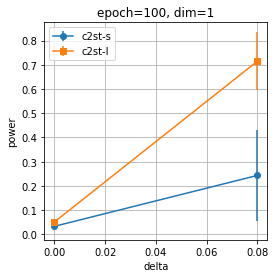

In [12]:
fig = plt.figure(figsize= (4,4))
plt.errorbar(delta_list, c2st_s_power_adam_mean, yerr=c2st_s_power_adam_std, fmt='-o',label='c2st-s')
plt.errorbar(delta_list, c2st_l_power_adam_mean, yerr=c2st_l_power_adam_std, fmt='-s',label='c2st-l')
plt.grid(); plt.legend(loc='upper left')
plt.ylabel('power');plt.xlabel('delta');
plt.title('epoch=%d, dim=%d' % (epochs, dim));plt.show()

## 2. Example of high dimensional Gaussian mixture


HDGM, ntr increases from 500 to 2000,

P = 1/2 (N( mu_1, Id) + N(mu_2, I_d)), mu_1 =0, mu_2 = 0.5*1_d

Q = 1/2 (N( mu_1, {[1,0.5; 0.5,1]; I_{d_2}}  + N( mu_2, {[1,-0.5; -0.5,1]; I_{d_2}} )


n_run=400, m_perm = 400, test power is averaged over n_rep = 20 replicas.

In [13]:
## HDGM data
rho = 0.5

def gen_HDGM_P(dim,n):
    Num_clusters = 2 # number of modes
    mu_mx = np.zeros([Num_clusters,dim])
    mu_mx[1] = mu_mx[1] + 0.5
    sigma_mx_1 = np.identity(dim)
    n_m1= np.int(n/2) #mode1
    n_m2= n-n_m1  #mode2
    X = np.zeros([n, dim])
    X[0:n_m1, :] = np.random.multivariate_normal(mu_mx[0], sigma_mx_1, n_m1)
    X[n_m1:n, :] = np.random.multivariate_normal(mu_mx[1], sigma_mx_1, n_m2)
    return np.float32(X)

def gen_HDGM_Q(dim,n, rho):
    Num_clusters = 2 # number of modes
    mu_mx = np.zeros([Num_clusters,dim])
    mu_mx[1] = mu_mx[1] + 0.5
    sigma_mx_2 = [np.identity(dim),np.identity(dim)]
    sigma_mx_2[0][0,1] = rho 
    sigma_mx_2[0][1,0] = rho
    sigma_mx_2[1][0,1] = -rho
    sigma_mx_2[1][1,0] = -rho
    n_m1= np.int(n/2) #mode1
    n_m2= n-n_m1     #mode2
    X = np.zeros([n, dim])
    X[0:n_m1, :] = np.random.multivariate_normal(mu_mx[0], sigma_mx_2[0], n_m1)
    X[n_m1:n, :] = np.random.multivariate_normal(mu_mx[1], sigma_mx_2[1], n_m2)
    return np.float32(X)

In [14]:
# classification network architecture
dim = 10
num_neurons = 128;
    
class nn_two_hidden_layer_classif(nn.Module):
    def __init__(self):
        super( nn_two_hidden_layer_classif, self).__init__()
        input_dim = dim
        num_classes = 2
        
        self.fc1 = nn.Linear(input_dim, num_neurons ) 
        self.fc2 = nn.Linear(num_neurons, num_neurons) 
        self.fc3 = nn.Linear(num_neurons, num_classes) 

    def forward(self, x):        
        x = F.relu(self.fc1(x)) #relu activation function
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

In [15]:
# data parameters
ntr_list = np.array([500, 1000, 1500, 2000]) 

# testing parameters
m_perm = 400 # boostrap parameter
n_run = 100 #400 #50 # number of tests to count rejectoin rate
n_replica = 10 #20 #10 #overall replicas
    #change n_run, n_replica to be smaller to run in shorter time, 
    #n_run=400, n_replica=20 takes about 15 min to run

# c2st training parameter
learning_rate_c = 1e-3
batch_size = 32
epochs =  20 #10 
print(f'epochs={epochs:d}, batch_size={batch_size:d}\n')


epochs=20, batch_size=32




 ntr=500, nXtr=250, nYtr=250

replica=0
C2ST-S power=0.06, C2ST-L power=0.11


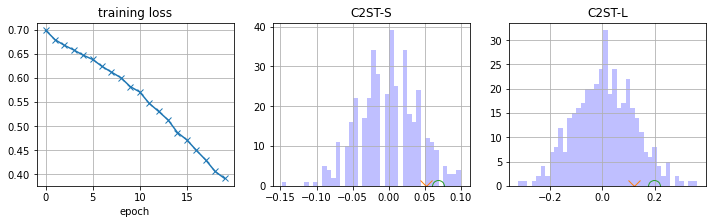

C2ST-S power=0.07, C2ST-L power=0.1
C2ST-S power=0.09, C2ST-L power=0.08
C2ST-S power=0.03, C2ST-L power=0.09
C2ST-S power=0.06, C2ST-L power=0.08
C2ST-S power=0.08, C2ST-L power=0.13
C2ST-S power=0.05, C2ST-L power=0.1
C2ST-S power=0.0, C2ST-L power=0.04
C2ST-S power=0.07, C2ST-L power=0.08
C2ST-S power=0.09, C2ST-L power=0.07

 ntr=1000, nXtr=500, nYtr=500

replica=0
C2ST-S power=0.31, C2ST-L power=0.51


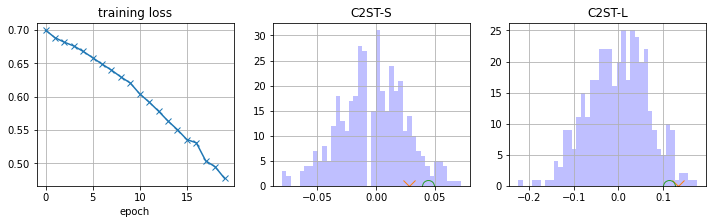

C2ST-S power=0.22, C2ST-L power=0.24
C2ST-S power=0.17, C2ST-L power=0.27
C2ST-S power=0.34, C2ST-L power=0.58
C2ST-S power=0.21, C2ST-L power=0.23
C2ST-S power=0.17, C2ST-L power=0.28
C2ST-S power=0.21, C2ST-L power=0.24
C2ST-S power=0.19, C2ST-L power=0.31
C2ST-S power=0.37, C2ST-L power=0.33
C2ST-S power=0.27, C2ST-L power=0.51

 ntr=1500, nXtr=750, nYtr=750

replica=0
C2ST-S power=0.35, C2ST-L power=0.57


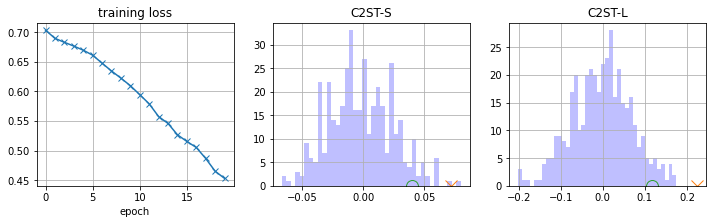

C2ST-S power=0.38, C2ST-L power=0.75
C2ST-S power=0.46, C2ST-L power=0.81
C2ST-S power=0.39, C2ST-L power=0.59
C2ST-S power=0.4, C2ST-L power=0.74
C2ST-S power=0.46, C2ST-L power=0.77
C2ST-S power=0.3, C2ST-L power=0.58
C2ST-S power=0.6, C2ST-L power=0.82
C2ST-S power=0.26, C2ST-L power=0.43
C2ST-S power=0.39, C2ST-L power=0.6

 ntr=2000, nXtr=1000, nYtr=1000

replica=0
C2ST-S power=0.56, C2ST-L power=0.82


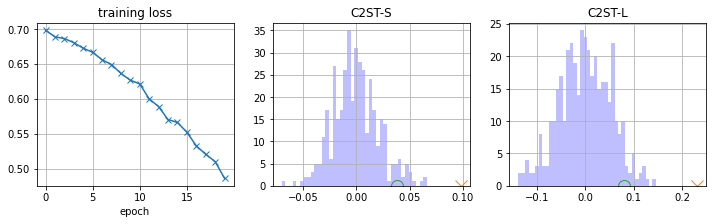

C2ST-S power=0.51, C2ST-L power=0.77
C2ST-S power=0.73, C2ST-L power=0.89
C2ST-S power=0.64, C2ST-L power=0.86
C2ST-S power=0.43, C2ST-L power=0.68
C2ST-S power=0.54, C2ST-L power=0.89
C2ST-S power=0.55, C2ST-L power=0.82
C2ST-S power=0.3, C2ST-L power=0.66
C2ST-S power=0.51, C2ST-L power=0.67
C2ST-S power=0.66, C2ST-L power=0.86
Running time: 136.37599301338196 seconds


In [16]:
# compare test power under H1
start = time.time() #time the code

c2st_s_vote_adam = np.zeros([ ntr_list.shape[0], n_replica, n_run ])
c2st_l_vote_adam = np.zeros([ ntr_list.shape[0], n_replica, n_run ])

for irow in range(ntr_list.shape[0]):
    ntr = ntr_list[irow]
    # training and test set sizes
    nXtr = np.int(ntr/2)
    nYtr = nXtr
    nXte, nYte = nXtr, nYtr
    nX, nY = nXtr+nXte, nYtr+nYte
    ntr, nte = nXtr+nYtr, nXte+nYte
    print(f'\n ntr={ntr:d}, nXtr={nXtr:d}, nYtr={nYtr:d}\n')
    
    for irep in range(n_replica):
        if np.mod(irep,10) == 0:
            print(f'replica={irep:d}')
    
        ## generate data, training-testing splitting
        X = gen_HDGM_P(dim, nX)
        Y = gen_HDGM_Q(dim, nY, rho)
        
        idxX=torch.randperm(nX).numpy()
        idxY=torch.randperm(nY).numpy()
        data_tr = torch.tensor( np.concatenate( (X[idxX[0:nXtr],:],  Y[idxY[0:nYtr],:]), axis=0) )
        labels_tr = torch.tensor(np.concatenate( (np.zeros(nXtr),  np.ones(nYtr)), axis=0), dtype=int)        
        #data_te =  torch.tensor(np.concatenate( (X[idxX[nXtr:nX],:],  Y[idxY[nYtr:nY],:]), axis=0))
        #labels_te = torch.tensor(np.concatenate( (np.zeros(nXte),  np.ones(nYte)), axis=0), dtype=int)

        ### C2ST-S test: training ###
        model_c = nn_two_hidden_layer_classif().to(device) #init model
        training_data = torch.utils.data.TensorDataset(data_tr, labels_tr )
        train_dataloader = torch.utils.data.DataLoader(training_data, 
                                        batch_size= batch_size, shuffle=True)
        
        #init model
        model_c = nn_two_hidden_layer_classif().to(device) 
        # optimizer
        optimizer_c = optim.Adam(model_c.parameters(), 
                                   lr= learning_rate_c)
        model_c.train()

        # loop of training
        train_loss_all, train_acc_all  = np.zeros(epochs), np.zeros(epochs)
        for t in range(epochs):
            #print(f"Epoch {t+1}\n-------------------------------")
            train_loss_all[t], train_acc_all[t]=train_loop(train_dataloader, model_c, optimizer_c)
    
        # loop for ntest many tests
        for irun in range(n_run):
            ## generate data, training-testing splitting
            X = gen_HDGM_P(dim, nX)
            Y = gen_HDGM_Q(dim, nY, rho)
            idxX=torch.randperm(nX).numpy()
            idxY=torch.randperm(nY).numpy()
            data_te =  torch.tensor(np.concatenate( (X[idxX[nXtr:nX],:],  Y[idxY[nYtr:nY],:]), axis=0))
            labels_te = torch.tensor(np.concatenate( (np.zeros(nXte),  np.ones(nYte)), axis=0), dtype=int)
            # test statistic
            with torch.no_grad():
                num_classes = 2
                # forward pass
                outputs_te = model_c(data_te).reshape([-1,num_classes])
                pred_te = F.log_softmax(outputs_te, dim=1)
                correct = (pred_te.argmax(1) == labels_te).type(torch.float).sum().item()
                test_acc =correct/nte 
            
            logit_te = outputs_te.detach().numpy()
        
            ### C2ST-S test
            gte = np.float32(np.sign(logit_te[:,0])>0)
            eta, etastore, talpha = perm_test(gte, labels_te, m_perm );
            # record the voet by rejection rule
            c2st_s_vote_adam[irow,irep,irun] =  np.float32( eta > talpha );
        
            if irep == 1 and irun ==1:
                # plot the histogram
                plt.figure(figsize=(12, 3))
                plt.subplot(1,3,1)
                plt.plot(train_loss_all,'x-');
                plt.xlabel('epoch'); plt.grid(); plt.title('training loss');
                plt.subplot(1,3,2)
                plt.hist( etastore, bins=40, facecolor='b', alpha=0.25)
                plt.plot( eta, 0, marker='x', markerfacecolor='red', markersize=12)
                plt.plot( talpha, 0, marker='o', markerfacecolor='green',fillstyle='none', markersize=12)
                plt.grid();plt.title('C2ST-S');
              
            ### C2ST-L test ###
            gte = logit_te[:,0]-logit_te[:,1];
            eta, etastore, talpha = perm_test(gte, labels_te, m_perm );
            c2st_l_vote_adam[irow,irep,irun] =  np.float32( eta > talpha );   

            if irep == 1 and irun ==1:
                # plot the histogram
                plt.subplot(1,3,3)
                plt.hist( etastore, bins=40, facecolor='b', alpha=0.25)
                plt.plot( eta, 0, marker='x', markerfacecolor='red', markersize=12)
                plt.plot( talpha, 0, marker='o', markerfacecolor='green',fillstyle='none', markersize=12)
                plt.grid();plt.title('C2ST-L');plt.show()

        #print test power estimated from this replica
        power_s = np.mean(c2st_s_vote_adam[irow,irep,:])
        power_l = np.mean(c2st_l_vote_adam[irow,irep,:])
        print(f'C2ST-S power={power_s}, C2ST-L power={power_l}')
        
            
end = time.time()        
print("Running time:", end - start, "seconds")     
    
    

In [17]:
c2st_s_power_adam_test = np.mean( c2st_s_vote_adam, axis=2)
c2st_s_power_adam_mean = np.mean(c2st_s_power_adam_test, axis=1)
c2st_s_power_adam_std = np.std(c2st_s_power_adam_test, axis=1)
c2st_l_power_adam_test = np.mean( c2st_l_vote_adam, axis=2)
c2st_l_power_adam_mean = np.mean(c2st_l_power_adam_test, axis=1)
c2st_l_power_adam_std = np.std(c2st_l_power_adam_test, axis=1)

print(c2st_s_power_adam_mean)
print(c2st_s_power_adam_std)
print(c2st_l_power_adam_mean)
print(c2st_l_power_adam_std)

[0.06  0.246 0.399 0.543]
[0.02645751 0.06843975 0.08938121 0.11506954]
[0.088 0.35  0.666 0.792]
[0.02315167 0.12489996 0.12257243 0.08681014]


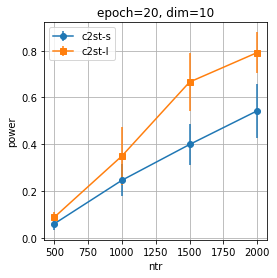

In [18]:
fig = plt.figure(figsize= (4,4))
plt.errorbar(ntr_list, c2st_s_power_adam_mean, yerr=c2st_s_power_adam_std, fmt='-o',label='c2st-s')
plt.errorbar(ntr_list, c2st_l_power_adam_mean, yerr=c2st_l_power_adam_std, fmt='-s',label='c2st-l')
plt.grid(); plt.legend(loc='upper left')
plt.ylabel('power');plt.xlabel('ntr');
plt.title('epoch=%d, dim=%d' % (epochs, dim));plt.show()

In [19]:
n_replica, n_run

(10, 100)